
<table><tr>
    <td><img src="imagenes/Macc.png"/></td>
    <td>Semillero de Modelación y Simulación de Fenómenos Sociales</td>
</tr></table>

# Simulación del Modelo del bar El Farol

## Descripción del modelo

En el presente modelo se tiene una población de $N$ individuos, quienes deben tomar la decisión de si acudirán o no al bar llamado "El Farol". Cada agente toma esta decisión de manera independiente a los demás, y se realiza de manera simultánea. 

<table><tr>
    <td><img src="imagenes/ElFarol1.jpeg"/></td>
    <td><img src="imagenes/ElFarol2.jpeg"/></td>
</tr></table>

Si el total de acudientes supera un umbral $\mu$, entonces El Farol se congestionará y los individuos que hayan ido al bar no tendrán una buena experiencia (recompensa=-1). Por otro lado, si el total de los acudientes no supera este umbral, quienes hayan asistido podrán disfrutar su estadía en el bar (recompensa=1). Adicionalmente, si un individuo no asiste al bar, será indiferente al estado de El Farol (recompensa=0). Cada agente intentará tomar la mejor decisión posible con respecto a asistir o no al bar. Esta situación se repetirá por un número $k$ de iteraciones. 

## Suposiciones de nuestra simulación

**Políticas**

Los agentes que simularemos tendrán memoria de 1 iteración. Es decir, el agente recordará la decisión que tomó en la iteración inmediatamente anterior (estrategia) así como la ganancia que obtuvo (recompensa). Cada individuo empleará de manera diferente esta información, siguiendo diferentes políticas. En nuestro modelo sólo hay tres posibles combinaciones de estrategias y recompensas, a saber:

(no ir a El Farol, recompensa 0) 
(ir a El Farol, recompensa 1) 
(ir a El Farol, recompensa -1)

Estas combinaciones se codifican de la siguiente manera, teniendo en cuenta que no ir al bar es 0 e ir es 1:

(0, 0)  
(1, 1)   
(1, -1)

Para cada combinación, el agente tiene dos opciones en la ronda $n+1$: ir o no ir. Esto nos da ocho políticas posibles.

**Aprendizaje**

Asumimos que los agentes están conectados mediante una red social. Esta red determina la vecindad de cada agente. Después de cada ronda, los agentes revisan la ganancia recibida en su vecindad y adoptan la política del vecino con mayor puntaje. Si nadie tiene un mejor puntaje, continúan con la política que tenían.

## Implementación en Python

In [1]:
import pandas as pd
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import redes
import ElFarolFunciones as F
import seaborn as sns
import redes1
import copy
import igraph as ig

# Comando para mostrar gráficos en notebook
%matplotlib inline

#### AGENTES 
Los agentes que se simularán tendrán 4 atributos:

**Estado**: Es la estrategia tomada por el agente y que puede ser ir al bar (1) o abstenerse de ir (0).

**Puntaje:** Puntaje obtenido. Hay tres posibilidades:

- **1** Si fue y la proporción de agentes que fueron fue menor que el $\mu $ determinado ($\mu=0.5$).
- **0**, si decidió no ir.
- **-1**, si fue y la proporción de agentes que fueron fue mayor que el $\mu$ determinado ($\mu=0.5$).

**Politica**: Es la forma en que los agentes toman la decisión de actuar en la siguiente ronda dada la situación actual, en términos de su estado y puntaje.

**Vecinos:** Los vecinos son los agentes conectados mediante la red. Son los únicos sobre los que un agente puede tener información, en términos de puntaje y política.

La impementación en Python de estos atributos tiene la característica siguiente. Cada atributo se almacena como una lista, la cual guarda la información correspondiente por cada ronda. Esto es, por ejemplo, `agente.estado[0]` es el estado del agente en la primera ronda.

In [41]:
class agente:
    def __init__(self, estados, scores, politicas, vecinos):
        self.estado = estados # lista
        self.score = scores # lista
        self.politica = politicas # lista
        self.vecinos = vecinos

    def __str__(self):
        return "E:{0}, S:{1}, P:{2}, Vecinos:{3}".format(self.estado, self.score,self.politica,self.vecinos)

Recordemos que las políticas representan la toma de decisiones de los agentes de la ronda $n$ a la ronda $n+1$. Para ello, cada agente consulta tanto la estrategia de la ronda $n$, como la recompensa obtenida. 

In [42]:
def crear_politicas():
    politicas = [
    {(0,0): 0, (1,1): 0, (1, -1): 0}, #0
    {(0,0): 0, (1,1): 0, (1, -1): 1}, #1
    {(0,0): 0, (1,1): 1, (1, -1): 0}, #2
    {(0,0): 0, (1,1): 1, (1, -1): 1}, #3
    {(0,0): 1, (1,1): 0, (1, -1): 0}, #4
    {(0,0): 1, (1,1): 0, (1, -1): 1}, #5
    {(0,0): 1, (1,1): 1, (1, -1): 0}, #6
    {(0,0): 1, (1,1): 1, (1, -1): 1}, #7
    ]
    return politicas


Utilizando la clase **agente** podemos generar agentes aleatorios creando objetos de esta clase a los que se les asigna un estado y una política al azar. Una vez conocido el estado inicial de todos los agentes, se procede a calcular la proporción de agentes que fueron al bar, mediante la función `calculamedio()`. Dependiendo de este resultado, se le asigna un puntaje a cada agente. Así pues, esta función recibe como parámetro el número de agentes que se quieren crear y retorna una lista con los agentes nuevos.

In [43]:
def crear_agentes_aleatorios(Num_agentes, politicas, UMBRAL):
    Agentes = []
    for i in range(Num_agentes):
        Agentes.append(agente([rd.randint(0,1)], [], [rd.randint(0,7)], []))

    X = F.calcula_medio(Agentes)
    
    for a in Agentes:
        if a.estado[-1] == 1:
            if X > 0.5:
                a.score.append(-1)
            else:
                a.score.append(1)
        else:
            a.score.append(0)

    # Leyendo red de archivo para incluir vecinos
    F.leer_red(Agentes)

    return Agentes

Si queremos que haya más interacción entre los agentes, se utiliza la 
función `agentes_aprenden` la cual recibe como parámetro la lista de
agentes y compara el resultado de la última ronda con el de sus vecinos.
Cada agente se acoge a la política del vecino con mayor puntaje, si nadie tiene
un mejor puntaje continúa con la política que tenía.

In [113]:
def agentes_aprenden(Agentes, ronda):   
    #Los agentes copian la politica del ganador de la Ronda
    for agente in Agentes:
        maximo = agente.score[ronda]
        maximo_vecino = Agentes.index(agente)
        politica = agente.politica[ronda - 1]
        print("Considerando agente", maximo_vecino)
        print(agente)
        print("Puntaje de agente:", maximo, end = "")
        puntajes_vecinos = [Agentes[index_vecino].score[ronda] for index_vecino in agente.vecinos]
        print(" Puntajes de los vecinos:", puntajes_vecinos)
        if len(puntajes_vecinos) > 0:
            if max(puntajes_vecinos) > maximo:
                maximo_vecino = agente.vecinos[np.argmax(puntajes_vecinos)]               
                politica = Agentes[maximo_vecino].politica[ronda - 1]
                print('Se imita la politica', politica,'del vecino', maximo_vecino)
            else:
                print('Agente', maximo_vecino, 'no necesita aprender.')
        else:
            print('El agente', maximo_vecino, 'no tiene vecinos')
        agente.politica.append(politica)
    return Agentes

Con las funciones anteriores, estamos listos para hacer la simulación, definiendo los parámetros iniciales:

In [114]:
Num_agentes = 10
Num_iteraciones = 10
TIPO_RED = 0 # CAMBIE ESTE VALOR PARA VER DIFERENTES TIPOS DE REDES
PARS = [Num_agentes, 0.1]
# Generando red a archivo
if TIPO_RED == 0:
    redes.random_graph(*PARS)
#    redes1.create_graph(PARS[0], "GRG", PARS[1], True)    
elif TIPO_RED == 1:
    redes.small_world(*PARS)
elif TIPO_RED == 2:
    redes.scale_free(PARS[0], PARS[0]/4, PARS[0]/8, PARS[1]*0.6, PARS[1])
elif TIPO_RED == 3:    
    redes1.create_graph(Num_agentes, "CloseRing",0,True)    

Corra esta celda para ver el grafo generado:

(0.0, 1.0, 0.0, 1.0)

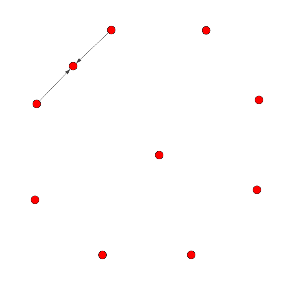

In [115]:
fig, axes = plt.subplots(figsize=(5, 5))
arr_img_graph = plt.imread("./imagenes/red.png", format='png')
image_graph = OffsetImage(arr_img_graph, zoom=0.4)
image_graph.image.axes = axes
ab = AnnotationBbox(image_graph, [0.5, 0.5], frameon=False)
axes.add_artist(ab)
plt.axis('off')

In [116]:
def simulacion(Num_agentes, Num_iteraciones, UMBRAL, inicial, N, PARS):
    politicas = crear_politicas()
    agentes = crear_agentes_aleatorios(Num_agentes, politicas, UMBRAL)
    print("****************************")
    print("Agentes iniciales:")
    for a in agentes:
        print(a)
    print("****************************")
    print("")
    for i in range(Num_iteraciones):
        print("==========================")
        print("Ronda", i)
        agentes = F.juega_ronda(agentes, politicas, UMBRAL)
        for a in agentes:
            print(a)
        agentes = agentes_aprenden(agentes, i + 1)
    data = F.crea_dataframe_agentes(agentes, Num_iteraciones, PARS, N)
    F.guardar(data, 'agentes.csv', inicial)
        

## Correr simulación

In [117]:
identificador = 0
UMBRAL = 0.5
inicial = True
simulacion(Num_agentes, Num_iteraciones, UMBRAL, inicial, identificador, PARS)

****************************
Agentes iniciales:
E:[1], S:[-1], P:[3], Vecinos:[]
E:[0], S:[0], P:[1], Vecinos:[]
E:[1], S:[-1], P:[5], Vecinos:[9]
E:[0], S:[0], P:[6], Vecinos:[9]
E:[1], S:[-1], P:[7], Vecinos:[]
E:[0], S:[0], P:[4], Vecinos:[]
E:[1], S:[-1], P:[1], Vecinos:[]
E:[1], S:[-1], P:[0], Vecinos:[]
E:[0], S:[0], P:[6], Vecinos:[]
E:[1], S:[-1], P:[7], Vecinos:[2, 3]
****************************

Ronda 0
E:[1, 1], S:[-1, -1], P:[3], Vecinos:[]
E:[0, 0], S:[0, 0], P:[1], Vecinos:[]
E:[1, 1], S:[-1, -1], P:[5], Vecinos:[9]
E:[0, 1], S:[0, -1], P:[6], Vecinos:[9]
E:[1, 1], S:[-1, -1], P:[7], Vecinos:[]
E:[0, 1], S:[0, -1], P:[4], Vecinos:[]
E:[1, 1], S:[-1, -1], P:[1], Vecinos:[]
E:[1, 0], S:[-1, 0], P:[0], Vecinos:[]
E:[0, 1], S:[0, -1], P:[6], Vecinos:[]
E:[1, 1], S:[-1, -1], P:[7], Vecinos:[2, 3]
Considerando agente 0
E:[1, 1], S:[-1, -1], P:[3], Vecinos:[]
Puntaje de agente: -1 Puntajes de los vecinos: []
El agente 0 no tiene vecinos
Considerando agente 1
E:[0, 0], S:[0, 0],

Considerando agente 0
E:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], S:[-1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1], P:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3], Vecinos:[]
Puntaje de agente: -1 Puntajes de los vecinos: []
El agente 0 no tiene vecinos
Considerando agente 1
E:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], S:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], P:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Vecinos:[]
Puntaje de agente: 0 Puntajes de los vecinos: []
El agente 1 no tiene vecinos
Considerando agente 2
E:[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1], S:[-1, -1, 1, 0, 1, 0, -1, -1, -1, -1, -1], P:[5, 5, 5, 5, 5, 5, 5, 5, 5, 5], Vecinos:[9]
Puntaje de agente: -1 Puntajes de los vecinos: [-1]
Agente 2 no necesita aprender.
Considerando agente 3
E:[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], S:[0, -1, 0, -1, 1, 1, -1, -1, -1, -1, -1], P:[6, 6, 7, 7, 7, 7, 7, 7, 7, 7], Vecinos:[9]
Puntaje de agente: -1 Puntajes de los vecinos: [-1]
Agente 3 no necesita aprender.
Considerando agente 4
E:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], S:[-1, -1, 1, -1, 1, 1, -1, -1

In [118]:
# Comando para leer a partir de datos
data = pd.read_csv('data/agentes.csv')
print("Numero de experimentos:", len(data.Identificador.unique()))
print(data.groupby('Identificador').Agente.value_counts())
data.head()

Numero de experimentos: 1
Identificador  Agente
0              0         10
               1         10
               2         10
               3         10
               4         10
               5         10
               6         10
               7         10
               8         10
               9         10
Name: Agente, dtype: int64


,Identificador,Parametro-0,Parametro-1,Agente,Ronda,Estado,Puntaje,Politica_lag,Politica,Puntaje_lead,Consistencia
0,0,10,0.1,0,0,1,-1,NaN,3,-1.0,NaN
1,0,10,0.1,0,1,1,-1,3.0,3,1.0,1.0
2,0,10,0.1,0,2,1,1,3.0,3,-1.0,1.0
3,0,10,0.1,0,3,1,-1,3.0,3,1.0,1.0
4,0,10,0.1,0,4,1,1,3.0,3,1.0,1.0


####  Asistencia por ronda

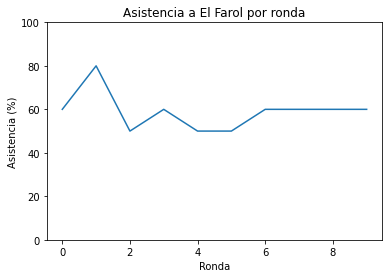

In [119]:
df1 = pd.DataFrame(data.groupby('Ronda')['Estado'].mean())
df1.columns = ['Asistencia']
df1['Asistencia'] = df1['Asistencia'] * 100
plt.ylabel('Asistencia (%)')
plt.ylim(0,100)
plt.title('Asistencia a El Farol por ronda')
df1['Asistencia'].plot()

####  Puntaje promedio que obtuvo cada política vs. ronda

Text(0, 0.5, 'Puntaje Promedio')

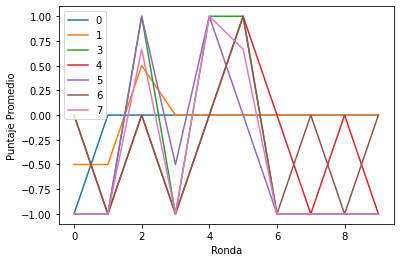

In [120]:
df = pd.DataFrame(data.groupby(['Ronda','Politica'])['Puntaje'].mean())\
                .reset_index()

fig, ax = plt.subplots()
for label,group in df.groupby('Politica'):
    group.plot(x='Ronda', y='Puntaje', ax=ax,label=label)
plt.ylabel("Puntaje Promedio")

#### Uso Politicas

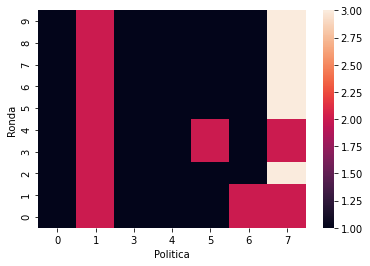

In [121]:
df = pd.DataFrame(data.groupby(['Ronda','Politica'])['Agente'].count()).reset_index()
df.columns = ['Ronda', 'Politica', 'num_agentes']
uso_politica = pd.pivot_table(
    data=df,
    index='Ronda',
    values='num_agentes',
    columns='Politica',
    aggfunc='sum'
).reset_index()

uso_politica = uso_politica.sort_values(by='Ronda',ascending=False)
uso_politica = uso_politica.set_index('Ronda')
ax = sns.heatmap(uso_politica)

Text(0, 0.5, 'Cantidad total de agentes')

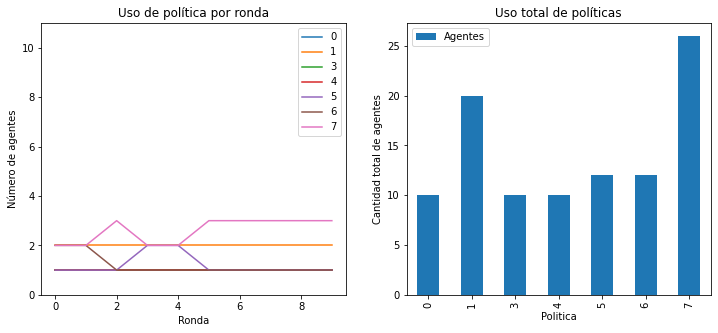

In [122]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
for label,group in df.groupby('Politica'):
    group.plot(x='Ronda', y='num_agentes', ax=ax[0],label=label)
ax[0].set_ylim([0,Num_agentes+1])
ax[0].set_title('Uso de política por ronda')
ax[0].set_ylabel('Número de agentes')
df1 = pd.DataFrame(data.groupby('Politica')['Agente'].count())
df1.columns = ['Agentes']
#ax[1].plot(df.index, df['Agentes'])
df1.plot(kind="bar", ax = ax[1])
ax[1].set_title('Uso total de políticas')
ax[1].set_ylabel('Cantidad total de agentes')

#### Distribución de la recompensa

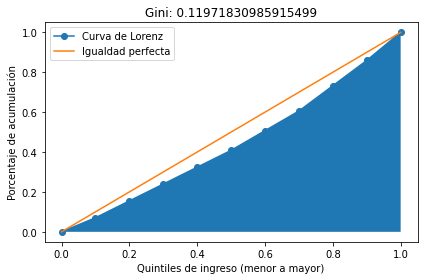

In [123]:
def gini(x):
        # The rest of the code requires numpy arrays.
        x = np.asarray(x) #convierte x en un vector
        sorted_x = np.sort(x) #los organiza de menor a mayor
        n = len(x) #tamaño del vector x
        cumx = np.cumsum(sorted_x, dtype=float)# va haciendo la suma acumulativa
        gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n #esta es una formula muy rara, esta en alternate expression de Wikipedia
        cumx = cumx/cumx[-1] #normalizando para que se vea en la grafica bien
        cumx = [0] + list(cumx)
        pe_line = np.linspace(start=0.0, stop=1.0, num=len(cumx))
        # The above formula, with all weights equal to 1 simplifies to:
        return gini, pe_line, cumx

data_aux = data.copy()
data_aux['Puntaje normalizado'] = data_aux['Puntaje'] + 1
data_aux = data_aux.groupby('Agente')['Puntaje normalizado'].sum().reset_index()
recompensa = data_aux['Puntaje normalizado'].values
gini, pe_line,cumx = gini(recompensa)
plt.plot(pe_line, cumx, label='Curva de Lorenz', marker="o")
plt.plot(pe_line, pe_line, label='Igualdad perfecta')
plt.fill_between(pe_line, cumx)
plt.title('Gini: {}'.format(gini), fontsize=12)
plt.ylabel('Porcentaje de acumulación', fontsize=10)
plt.xlabel('Quintiles de ingreso (menor a mayor)', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

**Aprendizaje de los agentes**

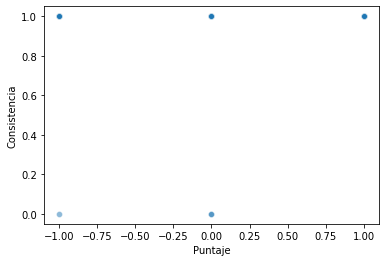

In [127]:
sns.scatterplot(x=data['Puntaje'], y=data['Consistencia'], alpha=0.5)